## Imports

In [1]:
import time
import pyswarms as ps
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from base64 import b64encode
from IPython.display import HTML
plt.style.use('ggplot')
from numba import jit, njit

# jitted

In [139]:
@njit
def S(z: float, phi: np.array([float])) -> float:
  if z <= abs(phi[6]):
    return 0
  if z >= abs(phi[5]):
    return 1
  else:
    return 0.5 - 0.5 * np.tanh(1/(z-abs(phi[5]))+1/(z-abs(phi[6])))


In [140]:
@njit
def Al(v: np.array([float]), phi: np.array([float]), i: int) -> np.array([float]):
  res = np.zeros(int(phi[16]))
  
  for j in range(int(phi[15]+1)):
    if j == i:
      continue
    res += 1/(phi[15]+1) * (abs(phi[2]) / ((1 + np.linalg.norm(v[i]-v[j]) ** 2)) ** abs(phi[4]))* (v[int(phi[15]+1)+j]-v[int(phi[15]+1)+i]) * S(np.dot((v[j]-v[i])/np.linalg.norm(v[i]-v[j]), v[int(phi[15]+1)+i]/np.linalg.norm(v[int(phi[15]+1)+i])), phi)
      
  return res

In [141]:
@jit
def F_0(v: np.array([float]), phi: np.array([float]), i: int) -> np.array([float]):
  if i == 0:
    return np.zeros(int(phi[16]))
#   print('\n(**)i = {}\n phi[3]= {},\n phi[7]= {},\n phi[8]= {},\n phi[9]= {},\n phi[10]= {},\n norm = {},\n exp_7_8 = {},\n exp_9_10 = {},\n vec_uni = {}'.format(
#     i, phi[3], phi[7], phi[8], phi[9], phi[10], np.linalg.norm(v[i]- v[0]) , phi[7]/phi[8] * np.exp(-np.linalg.norm(v[i]- v[0])/phi[8]), phi[9]/phi[10] * np.exp(-np.linalg.norm(v[i]- v[0])/phi[10]), (v[i]- v[0])/np.linalg.norm(v[i]- v[0])))
  
  return - abs(phi[3]) * (v[i]- v[0])/np.linalg.norm(v[i]- v[0]) * (abs(phi[7]/phi[8]) * np.exp(-np.linalg.norm(v[i]- v[0])/abs(phi[8])) - abs(phi[9]/phi[10]) * np.exp(-np.linalg.norm(v[i]- v[0])/abs(phi[10])))

In [142]:
@njit
def F(v: np.array([float]), phi: np.array([float]), i: int) -> np.array([float]):
  res = np.zeros(int(phi[16]))
  
  for j in range(int(phi[15]+1)):
    if j == i:
      continue
    res += -1/(phi[15]+1) * (v[i]- v[j])/np.linalg.norm(v[i]- v[j]) * (abs(phi[11]/phi[12]) * np.exp(-np.linalg.norm(v[i]- v[j])/abs(phi[12])) - abs(phi[13]/phi[14]) * np.exp(-np.linalg.norm(v[i]- v[j])/abs(phi[14])))
      
  return res

In [143]:
@jit
def f(v: np.array([float]), phi: np.array([float])) -> np.array([float]):

  res = np.zeros((int(2*phi[15]+2),int(phi[16])))

  for i in range(int(phi[15]+1)):
#     print('\n(**)i = {}\n phi[0]= {},\n phi[1]= {},\n norm = {},\n v_i = {},\n F_i = {},\n Al = {},\n F_0 = {}'.format(
#     i, phi[0], phi[1], np.linalg.norm(v[int(phi[15]+1)+i]) ** 2, v[int(phi[15]+1)+i], F(v, phi, i), Al(v, phi, i), F_0(v, phi, i)))
    res[i] = v[int(phi[15]+1)+i]
    res[int(phi[15]+1)+i] = (abs(phi[0]) - abs(phi[1]) * np.linalg.norm(v[int(phi[15]+1)+i]) ** 2) * v[int(phi[15]+1)+i] + F(v, phi, i) + Al(v, phi, i) + F_0(v, phi, i)

  return res

In [144]:
def run(q: np.array([float]), phi: np.array([float]), t: int, h: float, save = False, file ='animation') -> np.array([float]):

  r = int( t/h ) 

  res = np.zeros((r+1,4))  

  Q = np.zeros((r+2,int(2*phi[15]+2),int(phi[16])))
  Q[0] = q

  for j in range(r+1):
    K_1 = f(Q[j], phi)
    K_2 = f(Q[j] + h/2 * K_1, phi)
    K_3 = f(Q[j] + h/2 * K_2, phi)
    K_4 = f(Q[j] + h * K_2, phi)
    Q[j+1] = Q[j] + h/6 * (K_1 + 2*K_2 + 2*K_3 + K_4)


  if save :
    
    for j in range(r+1):
    
        res[j, 0] = X_t(Q[j], phi)
        res[j, 1] = V_t(Q[j], phi)
        res[j, 2] = mean_x(Q[j], phi)
        res[j, 3] = mean_v(Q[j], phi)
    
    fig = plt.figure(constrained_layout=True, figsize = (16, 9))
    gs = fig.add_gridspec(4, 3)


    if phi[16] == 2:
      ax0 = fig.add_subplot(gs[:,0:2])

      p01 = ax0.scatter(q[0,0], q[0,1], marker="o", color = "b")
      p02 = ax0.quiver(q[0,0], q[0,1], q[phi[15]+1,0] / (np.sqrt(q[phi[15]+1,0]**2+q[phi[15]+1,1]**2)), q[phi[15]+1,1] / (np.sqrt(q[phi[15]+1,0]**2+q[phi[15]+1,1]**2)), width= 0.001, headwidth=3, headlength=5, color='b')

      p03 = ax0.scatter(q[1:phi[15]+1,0], q[1:phi[15]+1,1], marker="o", color = "r")
      p04 = ax0.quiver(q[1:phi[15]+1,0], q[1:phi[15]+1,1], q[phi[15]+2:,0]/(np.sqrt(q[phi[15]+2:,0]**2+q[phi[15]+2:,1]**2)), q[phi[15]+2:,1]/(np.sqrt(q[phi[15]+2:,0]**2+q[phi[15]+2:,1]**2)), width= 0.001, headwidth=3, headlength=5)
    else:
      ax0 = fig.add_subplot(gs[:,0:2], projection='3d') 
      ax0.set_zlim(Q[:,:phi[15]+1,2].min() - 3,Q[:,:phi[15]+1,2].max() + 3) 

      p01 = ax0.scatter(q[0,0:1], q[0,1:2], q[0,-1], marker="*", color = "b" )
      # nm1 = np.sqrt(q[phi[15]+1,0]**2 + q[phi[15]+1,1]**2 + q[phi[15]+1,2]**2)
      p02 = ax0.quiver(q[0,0], q[0,1], q[0,2], q[phi[15]+1,0], q[phi[15]+1,1], q[phi[15]+1,2], length=1, normalize =True, colors='b', linewidth =1)

      # nm2 = np.sqrt(q[phi[15]+2:,0]**2 + q[phi[15]+2:,1]**2 + q[phi[15]+2:,2]**2)
      p03 = ax0.scatter(q[1:phi[15]+1,0:1], q[1:phi[15]+1,1:2], q[1:phi[15]+1,-1], marker="o", color = "r")
      p04 = ax0.quiver(q[1:phi[15]+1,0], q[1:phi[15]+1,1], q[1:phi[15]+1,2], q[phi[15]+2:,0], q[phi[15]+2:,1], q[phi[15]+2:,2], length=1, normalize =True, colors='k', linewidth =1)

      def quiver_data_to_segments(X, Y, Z, u, v, w, length=1):
        segments = (X, Y, Z, X+v*length, Y+u*length, Z+w*length)
        segments = np.array(segments).reshape(6,-1)
        return [[[x, y, z], [u, v, w]] for x, y, z, u, v, w in zip(*list(segments))]

    ax0.set_xlim(Q[:,:phi[15]+1,0].min() - 5,Q[:,:phi[15]+1,0].max() + 5)
    ax0.set_ylim(Q[:,:phi[15]+1,1].min() - 3,Q[:,:phi[15]+1,1].max() + 3)
      
    ax1 = fig.add_subplot(gs[0, 2])
    p1 = ax1.plot([], [], 'b')[0]

    ax1.set_xlabel("time")
    ax1.set_ylabel("X(t)")
    ax1.set_title('$X(t)$')
    ax1.set_xlim(0,t+1)
    ax1.set_ylim(res[:, 0].min() -2, res[:, 0].max() + 3)

    ax2 = fig.add_subplot(gs[1, 2])
    p2 = ax2.plot([],[], 'b')[0]
    ax2.set_xlim(0,t+1)
    ax2.set_ylim(min(res[:, 1].min(), dx_lim) -2, max(res[:, 1].max(), dx_lim) + 3)
    ax2.set_xlabel("time")
    ax2.set_ylabel("V(t)")
    ax2.set_title('$V(t)$')

    ax3 = fig.add_subplot(gs[2, 2])
    p3 = ax3.plot([], [],'b--', label='$sum(|x_i - x_0|)\;/\;(N+1)$')[0]
    ax3.plot(np.arange(t+1), dx_lim*np.ones(t+1), 'k', label='$ln(C^0_rl^0_a/(l^0_rC^0_a))*(l^0_al^0_r/(l^0_a-l^0_r))$')
    ax3.set_xlim(0,t+1)
    ax3.set_ylim(min(res[:, 2].min(), v_lim) - 2, max(res[:, 2].max(), v_lim) + 3)
    ax3.set_xlabel("time")
    ax3.set_ylabel("Distance")
    ax3.set_title('The distance between the agents and the leader')
    ax3.legend()

    ax4 = fig.add_subplot(gs[3, 2])
    p4 = ax4.plot([], [], 'b--', label='$sum(|v_i|)\;/\;(N+1)$')[0]
    ax4.plot(np.arange(t+1), v_lim*np.ones(t+1), 'k', label='$sqrt((alpha)/(beta))$')
    ax4.set_xlim(0,t+1)
    ax4.set_ylim(res[:, 3].min() - 2, res[:, 3].max() + 3)
    ax4.set_xlabel("time")
    ax4.set_ylabel("mean(|v|)")
    ax4.set_title('The mean norm of velocity')
    ax4.legend()

    def animate(i):  
        time = np.linspace(0,i*h,i+1)

        if phi[16]==2:

          p01.set_offsets(np.c_[Q[i,0,0], Q[i,0,1]])
          
          nrm1 = np.sqrt(Q[i,phi[15]+1,0]**2 + Q[i,phi[15]+1,0]**2)
          p02.set_offsets(np.c_[Q[i,0,0], Q[i,0,1]])
          p02.set_UVC(Q[i,phi[15]+1,0]/nrm1, Q[i,phi[15]+1,1]/nrm1)
          
          p03.set_offsets(np.c_[Q[i,1:phi[15]+1,0], Q[i,1:phi[15]+1,1]])
          
          nrm2 = np.sqrt(Q[i,phi[15]+2:,0]**2 + Q[i,phi[15]+2:,1]**2)
          p04.set_offsets(np.c_[Q[i,1:phi[15]+1,0], Q[i,1:phi[15]+1,1]])
          p04.set_UVC(Q[i,phi[15]+2:,0]/nrm2, Q[i,phi[15]+2:,1]/nrm2)

        else:
          p01._offsets3d = (Q[i,0,0:1], Q[i,0,1:2], Q[i,0,-1])
          
          # nrm1 = np.sqrt(Q[i,phi[15]+1,0]**2 + Q[i,phi[15]+1,0]**2)
          segs1 = quiver_data_to_segments(Q[i,0,0], Q[i,0,1], Q[i,0,2], Q[i,phi[15]+1,0], Q[i,phi[15]+1,1], Q[i,phi[15]+1,2], length=1)
          p02.set_segments(segs1)
          
          p03._offsets3d = (Q[i,1:phi[15]+1,0], Q[i,1:phi[15]+1,1], Q[i,1:phi[15]+1,2])
          
          # nrm2 = np.sqrt(Q[i,phi[15]+2:,0]**2 + Q[i,phi[15]+2:,1]**2)
          segs2 = quiver_data_to_segments(Q[i,1:phi[15]+1,0], Q[i,1:phi[15]+1,1], Q[i,1:phi[15]+1,2], Q[i,phi[15]+2:,0], Q[i,phi[15]+2:,1], Q[i,phi[15]+2:,2], length=1)
          p04.set_segments(segs2)

        p1.set_data(time, res[:i+1, 0])
        p2.set_data(time, res[:i+1, 1])
        p3.set_data(time, res[:i+1, 2])
        p4.set_data(time, res[:i+1, 3])


    anim = FuncAnimation(fig, animate, interval=100, frames=r+1)

    anim.save(f'{file}.gif')

    plt.close()
  return Q 




### Dispersion, disagreement and asymptotic behavior:

In [145]:
def X_t(v, phi):
  res = 0
  for i in range(int(phi[15])+1):
    for j in range(int(phi[15])+1):
      res += np.linalg.norm(v[i] - v[j])  
  return 0.5 / ((phi[15]+1)**2) * res
   

In [146]:
def V_t(v, phi):
  res = 0
  for i in range(int(phi[15])+1):
    for j in range(int(phi[15])+1):
      res += np.linalg.norm(v[int(phi[15])+1+i] - v[j+int(phi[15])+1])  
  return 0.5 / ((phi[15]+1)**2) * res

In [147]:
def mean_x(v, phi):
  res = 0
  for i in range(1,int(phi[15])+1):
    res += np.linalg.norm(v[i] - v[0])

  return (1 / phi[15]) * res 

In [148]:
def mean_v(v, phi):
  res = 0
  for i in range(int(phi[15])+1):
    res += np.linalg.norm(v[int(phi[15])+1+i])

  return (1 / (phi[15]+1)) * res 

# Initialisation 

In [149]:
def init_20(phi):

  global dx_lim, v_lim
  
  
  alpha = phi[0]
  beta = phi[1]

  gamma = phi[2]
  gamma_1 = phi[3]
  sigma = phi[4]

  d1 = phi[5]
  d2 = phi[6]

  C0_a = phi[7]
  l0_a = phi[8]
  C0_r = phi[9]
  l0_r = phi[10]

  C_a = phi[11]
  l_a = phi[12]
  C_r = phi[13]
  l_r = phi[14]

  N = phi[15]
  d = phi[16]


  dx_lim = np.log( (C0_r * l0_a) / (C0_a * l0_r) ) * (l0_a * l0_r) / (l0_a - l0_r)
  v_lim = np.sqrt(alpha/beta)

  res = np.zeros((2 * N + 2, d))

  res[0] = [20, 25]
    
  for i in range(10):
    res[1+i] = [2 * np.cos(np.pi * i / 5), 2 * np.sin(np.pi * i / 5)]
  
  for i in range(10):
    res[11+i] = [15 + 2 * np.cos(np.pi * i / 5), 2 * np.sin(np.pi * i / 5)]
    
  
  x = res[:N+1,:].copy()
    
  tmp = np.ones((21,2))
  x[:,0] = sum(x[:,0]) / (21) * tmp[:,0]
  x[:,1] = sum(x[:,1]) / (21) * tmp[:,1]


  res[N+1:,:] = np.sqrt(alpha/beta) * (res[:N+1,:] - x) / np.linalg.norm(res[:N+1,:])
  
  
  return res

In [150]:
def init_1(phi):

  global dx_lim, v_lim
  
  
  alpha = phi[0]
  beta = phi[1]

  gamma = phi[2]
  gamma_1 = phi[3]
  sigma = phi[4]

  d1 = phi[5]
  d2 = phi[6]

  C0_a = phi[7]
  l0_a = phi[8]
  C0_r = phi[9]
  l0_r = phi[10]

  C_a = phi[11]
  l_a = phi[12]
  C_r = phi[13]
  l_r = phi[14]

  N = phi[15]
  d = phi[16]


  dx_lim = np.log( (C0_r * l0_a) / (C0_a * l0_r) ) * (l0_a * l0_r) / (l0_a - l0_r)
  v_lim = np.sqrt(alpha/beta)

  res = np.zeros((2 * N + 2, d))
  res[0] = [20, 25]
  for i in range(12):
    res[1+i] = [2 * np.cos(np.pi * i / 6), 2 * np.sin(np.pi * i / 6)]
  for i in range(25):
    res[13+i] = [4 * np.cos(np.pi * 2*i / 25), 4 * np.sin(np.pi * 2*i / 25)]
  for i in range(12):
    res[38+i] = [15 + 2 * np.cos(np.pi * i / 6), 2 * np.sin(np.pi * i / 6)]
  res[50] = [15,0]
  for i in range(25):
    res[51+i] = [15 + 4 * np.cos(np.pi * 2*i / 25), 4 * np.sin(np.pi * 2*i / 25)]
  x = res[:N+1,:].copy()
  tmp = np.ones((76,2))
  x[:,0] = sum(x[:,0]) / (76) * tmp[:,0]
  x[:,1] = sum(x[:,1]) / (76) * tmp[:,1]


  res[N+1:,:] = np.sqrt(alpha/beta) * (res[:N+1,:] - x) / np.linalg.norm(res[:N+1,:])
  
  
  return res

# Plot functions

In [151]:
def plot_sys(v, phi):

  if phi[16] == 2:
    lx = v[0, 0]
    ly = v[0, 1]
    
    lvx = v[phi[15]+1,0]
    lvy = v[phi[15]+1,1]

    x = v[1:phi[15]+1,0]
    y = v[1:phi[15]+1,1]

    vx = v[phi[15]+2:,0]
    vy = v[phi[15]+2:,1]

    fig, ax = plt.subplots(figsize = (10,10))
    plt.xlim(min(min(x), lx) - 5,max(max(x), lx) + 5)
    plt.ylim(min(min(y), ly) - 3,max(max(y), ly) + 3)

    plt.scatter(lx, ly, marker="o", color = "b")
    plt.quiver(lx, ly, lvx, lvy, scale = 1, width= 0.001, headwidth=3, headlength=5, color='b')

    plt.scatter(x, y, marker="o", color = "r")
    plt.quiver(x, y, vx, vy, scale = 1, width= 0.001, headwidth=3, headlength=5)

    plt.show()

  else:
    lx = v[0, 0]
    ly = v[0, 1]
    lz = v[0, 2]
    
    lvx = v[phi[15]+1,0]
    lvy = v[phi[15]+1,1]
    lvz = v[phi[15]+1,2]

    x = v[1:phi[15]+1,0]
    y = v[1:phi[15]+1,1]
    z = v[1:phi[15]+1,2]

    vx = v[phi[15]+2:,0]
    vy = v[phi[15]+2:,1]
    vz = v[phi[15]+2:,2]

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(min(min(x), lx) - 5,max(max(x), lx) + 5)
    ax.set_ylim(min(min(y), ly) - 5,max(max(y), ly) + 5)
    ax.set_ylim(min(min(z), lz) - 5,max(max(z), lz) + 5)

    ax.scatter(lx, ly, lz, marker="*", color = "b" )
    ax.quiver(lx, ly, lz, lvx, lvy, lvz, length=3, colors='b', linewidth =1)

    ax.scatter(x, y, z, marker="o", color = "r")
    ax.quiver(x, y, z, vx, vy, vz, length=1, colors='k', linewidth =1)

    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')


    plt.show()

In [152]:
def plot_asym_behavior(w, t):

  r = np.arange(t+1)

  fig = plt.figure(constrained_layout=True, figsize = (16, 9))
  gs = fig.add_gridspec(2, 2)

  f_ax1 = fig.add_subplot(gs[0, 0])
  f_ax1.plot(r, w[:, 0])
  f_ax1.set_xlabel("time")
  f_ax1.set_ylabel("X(t)")
  f_ax1.set_title('$X(t)$')


  f_ax2 = fig.add_subplot(gs[0, 1])
  f_ax2.plot(r, w[:, 1])
  f_ax2.set_xlabel("time")
  f_ax2.set_ylabel("V(t)")
  f_ax2.set_title('$V(t)$')


  f_ax3 = fig.add_subplot(gs[1, 0])
  f_ax3.plot(r, w[:, 2], '--', label='$sum(|x_i - x_0|)\;/\;(N+1)$')
  f_ax3.plot(r, dx_lim * np.ones(t+1), 'k', label='$ln(C^0_rl^0_a/(l^0_rC^0_a))*(l^0_al^0_r/(l^0_a-l^0_r))$')
  f_ax3.set_xlabel("time")
  f_ax3.set_ylabel("Distance")
  f_ax3.set_title('The distance between the agents and the leader')
  f_ax3.legend()

  f_ax4 = fig.add_subplot(gs[1, 1])
  f_ax4.plot(r, w[:, 3], '--', label='$sum(|v_i|)\;/\;(N+1)$')
  f_ax4.plot(r, v_lim * np.ones(t+1), 'k', label='$sqrt((alpha)/(beta))$')
  f_ax4.set_xlabel("time")
  f_ax4.set_ylabel("mean(|v|)")
  f_ax4.set_title('The mean norm of velocity')
  f_ax4.legend()

# parameters

In [153]:
params_1 = (0.07 , 0.05 , 1 , 10 , 0.5 , np.cos(1.047) , np.cos(1.57), 10 , 50 , 25 , 1 , 20 , 100 , 50 , 2, 75, 2)

params_20 = (0.07 , 0.05 , 1 , 10 , 0.5 , np.cos(1.047) , np.cos(1.57), 10 , 50 , 25 , 1 , 20 , 100 , 50 , 2, 20, 2)

params_2 = (0.07, 0.05, 1, 10, 0.5, np.cos(1.047), np.cos(1.57), 10, 50, 25, 1, 50, 10, 20, 2, 61, 2)

# Parameter identification

In [234]:

def objective(phi: np.array):
  res = np.zeros(phi.shape[0])
  for k in range(phi.shape[0]):
    
#     phi[k][4:7] = params_20[4:7]
#     phi[k][11:13] = params_20[11:13]
    phi[k][15:] = params_20[15:]
    
    temp = run(Y, phi[k], 20, 1)

    res[k] = np.linalg.norm(Y_data[:-1] - temp[:-1]) ** 2

  return res 

In [235]:
# params = (alpha, beta, gamma, gamma_1, sigma, d1, d2, C0_a, l0_a, C0_r, l0_r, C_a, l_a, C_r, l_r, N, d)

In [236]:
Y = init_20(params_20)

In [237]:
Y_data = run(Y, params_20, 20, 1)

In [ ]:
%%time

# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.9, 'w':0.9}

a=1

# Create bounds
min_bound = np.zeroes(17)
max_bound = 100*np.ones(17)
bounds = (min_bound, max_bound)

# Call instance of GlobalBestPSO
optimizer = ps.single.GlobalBestPSO(n_particles=40, dimensions=17,
                                    options=options, init_pos=optimizer.pos_history[-1])
# Perform optimization
stats = optimizer.optimize(objective, iters=400, n_processes=8)

2021-06-22 01:44:27,097 - pyswarms.single.global_best - INFO - Optimize for 400 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.9}
pyswarms.single.global_best:   5%|▍         |19/400, best_cost=485<ipython-input-144-62c1fbf4fe07>:15: RuntimeWarning: overflow encountered in multiply
  Q[j+1] = Q[j] + h/6 * (K_1 + 2*K_2 + 2*K_3 + K_4)
pyswarms.single.global_best:  16%|█▌        |62/400, best_cost=485<ipython-input-144-62c1fbf4fe07>:15: RuntimeWarning: overflow encountered in multiply
  Q[j+1] = Q[j] + h/6 * (K_1 + 2*K_2 + 2*K_3 + K_4)
pyswarms.single.global_best: 100%|█████████▉|398/400, best_cost=99.7

In [211]:
stats #2000 iters with c2=0.6 sol for 10 / 1 params fixed: 4, 5, 6, 11, 12             pred8

(6.888027297825215e-27,
 array([ 7.00000000e-02, -5.00000000e-02, -1.00000000e+00,  1.00596178e+01,
         6.60823217e+00,  8.54698322e-01,  6.24782205e+00,  9.94073549e+00,
         5.00000000e+01,  2.48518387e+01,  1.00000000e+00,  4.93381959e+00,
         1.44042147e+01,  5.00000000e+01,  2.00000000e+00,  3.10664712e+00,
         1.05073417e+00]))

In [203]:
stats #2000 iters with c2=0.6 sol for 10 / 1  params fixed: 2, 4, 5, 6, 11, 12           pred7

(3.260332664781796e-25,
 array([-7.00000000e-02,  5.00000000e-02,  6.98364155e+00,  8.00372217e+00,
         3.44805025e+00,  2.96566042e+00,  2.29276928e+00,  1.24941868e+01,
         5.00000000e+01,  3.12354670e+01,  1.00000000e+00,  6.02274822e+00,
         3.25341514e-01,  5.00000000e+01,  2.00000000e+00, -6.35039992e-01,
         1.52756344e+00]))

In [27]:
stats #10000 iters with c2=0.6 sol for 10 / 1 all free                                    pred4

(12.428925541533408,
 array([-6.22945345e-03, -4.91148516e-02,  3.59096191e+01,  9.58180670e+00,
         2.04074194e+00,  1.87326282e+01,  7.12453121e+00,  1.18784648e+01,
         5.37808176e+01, -2.98628288e+01, -9.83289371e-01,  1.28728658e+03,
         1.22857504e+04,  5.32944625e+01,  1.87736785e+00,  8.93586071e-01,
         6.79171629e+00]))

In [36]:
stats #1000 iters with c2=0.7 sol for 10 / 0.25 all free

(42.213718407843125,
 array([-2.16121268e-03,  4.89362517e-02,  1.29742446e+01,  9.41939493e+00,
        -2.87798926e+00,  4.12748706e+00,  8.73885537e-04,  1.20566792e+01,
         5.31025329e+01,  2.82659154e+01, -1.05571114e+00,  3.72489176e+01,
         3.37007086e+02,  5.21699991e+01, -1.92770542e+00, -2.72875464e+00,
         2.89887733e+01]))

In [30]:
stats #1000 iters with c2=0.7 sol for 10 / 0.5 all free

(21.85678095739938,
 array([-9.83347528e-04,  4.87971101e-02,  3.63019297e+01,  9.91217114e+00,
         2.02982574e+01,  1.77592612e+00,  5.12077554e+00, -1.14405750e+01,
        -5.28330836e+01,  2.33290615e+01, -1.10419518e+00,  6.38597237e+01,
        -5.99289953e+02,  5.20420453e+01,  1.93033837e+00,  5.77588124e+00,
         9.57405789e+00]))

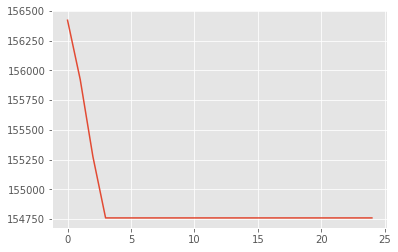

In [250]:
plt.plot(optimizer.cost_history[175:])
# objective(params_pred4)
# run(Y,params_pred6,100,0.5, save=True, file="test_pred6")
# optimizer.pos_history[-1]

In [44]:
params_20   = ( 0.07 ,           0.05 ,           1 ,              10 , 
                0.5 ,            np.cos(1.047) ,  np.cos(1.57),    10 ,
                50 ,             25 ,             1 ,              20 ,
                100 ,            50 ,             2,               20,
                2)

params_pred = ( 6.22712065e-02,  5.06104633e-02,  4.55374230e+00,  1.52257329e+01,
                1.31434289e+00,  2.10709514e+00,  3.15172943e+00,  6.65762399e+00,
                5.06755363e+01,  2.49981224e+01,  9.86426738e-01,  1.84465740e+01,
                1.04021877e+02,  4.99368921e+01,  1.97556702e+00,  20,
                2)
params_pred2 = ( 2.39064359e-01, 7.68831092e-02, 9.37504712e+00, 2.24346935e+01,
                 1.06140789e+01, 2.12767063e-02, 2.26398337e-01, 4.17479246e+00,
                 4.65354086e+01, 2.25497370e+01, 1.94129444e+00, 2.64774279e+01,
                 9.88482868e+01, 5.05689676e+01, 1.79416162e+00, 20,
                 2)

params_pred3 = (  4.61665940e-02,  4.72920198e-02,  1.77824176e+00,  3.27155919e+00,
                  6.69389722e-01,  5.62934398e-01,  9.44237439e-02,  3.17047517e+01,
                  5.30360005e+01,  5.81683321e+01,  1.09202426e+00,  2.92999387e+01,
                  1.82094659e+02,  5.04491220e+01,  1.94084459e+00,  20,
                  2)

params_pred4 = ( 6.22945345e-03,  4.91148516e-02,  3.59096191e+01,  9.58180670e+00,
                 2.04074194e+00,  1.87326282e+01,  7.12453121e+00,  1.18784648e+01,
                 5.37808176e+01,  2.98628288e+01,  9.83289371e-01,  1.28728658e+03,
                 1.22857504e+04,  5.32944625e+01,  1.87736785e+00,  20,
                 2)

params_pred5 = ( 2.16121268e-03,  4.89362517e-02,  1.29742446e+01,  9.41939493e+00,
                 2.87798926e+00,  4.12748706e+00,  8.73885537e-04,  1.20566792e+01,
                 5.31025329e+01,  2.82659154e+01,  1.05571114e+00,  3.72489176e+01,
                 3.37007086e+02,  5.21699991e+01,  1.92770542e+00,  20,
                 2)

params_pred6 = ( 9.83347528e-04,  4.87971101e-02,  3.63019297e+01,  9.91217114e+00,
                 2.02982574e+01,  1.77592612e+00,  5.12077554e+00,  1.14405750e+01,
                 5.28330836e+01,  2.33290615e+01,  1.10419518e+00,  6.38597237e+01,
                 5.99289953e+02,  5.20420453e+01,  1.93033837e+00,  20,
                 2)

params_pred7 = ( 7.00000000e-02,  5.00000000e-02,  1.00000000e+00,  8.00372217e+00,
                 5.00000000e-01,  np.cos(1.047) ,  np.cos(1.57)  ,  1.24941868e+01,
                 5.00000000e+01,  3.12354670e+01,  1.00000000e+00,  2.00000000e+01,
                 1.00000000e+02,  5.00000000e+01,  2.00000000e+00,  20,
                 2 )

params_pred8 = ( 7.00000000e-02, -5.00000000e-02, -1.00000000e+00,  1.00596178e+01,
                 5.00000000e-01,  np.cos(1.047) ,  np.cos(1.57)  ,  9.94073549e+00,
                 5.00000000e+01,  2.48518387e+01,  1.00000000e+00,  2.00000000e+01,
                 1.00000000e+02,  5.00000000e+01,  2.00000000e+00,  20,
                 2 )

# test

In [51]:
objective(np.array([[ 6.75089399e-02,  4.83759348e-02,  2.97404484e+00,  4.49835368e+00,
 -2.18877975e-01,np.cos(1.047), np.cos(1.57), 2.21491142e+01,  4.94508429e+01,  2.54305379e+00,
  3.15316226e+00, -3.02071074e+00,  3.07831543e+00,  2.32741483e+01,
  4.73761734e-01, 75, 2]]))

# 131.14808533       175.47627963  

array([175.47627963])

In [37]:
objective(np.array([[2.85847473e-02, 4.52504452e-02, 2.01671110e-01 ,1.02330002e+01 , 0.5, np.cos(1.047), np.cos(1.57), 10 , 50 , 25 , 1, 20 , 100 , 50 , 2 , 75, 2 ]]))

# 0.05067263

array([0.05067263])

In [ ]:
a = [1, 2, 3, 4, 5]
a[4:]

In [209]:
stats

(6.888027297825215e-27,
 array([ 7.00000000e-02, -5.00000000e-02, -1.00000000e+00,  1.00596178e+01,
         6.60823217e+00,  8.54698322e-01,  6.24782205e+00,  9.94073549e+00,
         5.00000000e+01,  2.48518387e+01,  1.00000000e+00,  4.93381959e+00,
         1.44042147e+01,  5.00000000e+01,  2.00000000e+00,  3.10664712e+00,
         1.05073417e+00]))

In [138]:
p = (0.07 , 0.05 , 1 , 5.66987287 , 0.5 , np.cos(1.047) , np.cos(1.57), 17.6370797 , 50 , 44.0926981 , 1 , 20 , 100 , 50 , 2, 20, 2)

objective(np.array([p]))

array([3.70009794e-13])

In [172]:
pp = (0.07 , 0.05 , 1 , 9.41722434 , 0.5 , np.cos(1.047) , np.cos(1.57), 10.6188402 , 50 , 26.5471004 , 1 , 20 , 100 , 50 , 2, 20, 2)

objective(np.array([[7.00000000e-02,  5.00000000e-02,  1.00000000e+00,  9.41722434e+00,
                     5.00000000e-01,  5.00000000e-01,  7.00000000e-04,  1.06188402e+01,
                     5.00000000e+01,  2.65471004e+01,  1.00000000e+00,  20,
                     100           ,  5.00000000e+01,  2.00000000e+00,  20,
                     2]]))

array([3.46801925e-13])

In [210]:
p = [stats[1][i] for i in range(17)]

objective(np.array([p]))

array([6.8880273e-27])